# How to create an NDVI Time series using openEO

This notebook presents an application case, that demonstrates how to display the NDVI (Normalized Difference Vegetation Index) timeseries for specific fields. The case study showcases the process of selecting the fields and generating average NDVI timeseries data for analysis and visualization.

## Setup

In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np

import openeo

Establish an authenticated connection to Copernicus Data Space Ecosystem openEO back-end.

In [2]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

## Basic NDVI Timeseries

We want to calculate the NDVI values in a couple of fields in a time window of a couple of months.

For simplicty, we load the field geometries as an inline GeoJSON feature collection:

In [3]:
fields = json.loads(
    """{
    "type": "FeatureCollection",
    "features": [
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.055945487931457, 51.222709834076504], [5.064972484168688, 51.221122565090525], [5.064972484168688, 51.221122565090525], [5.067474954083448, 51.218249806779134], [5.064827929485983, 51.21689628072789], [5.05917785594747, 51.217191909908095], [5.053553857094518, 51.21807492332223], [5.055945487931457, 51.222709834076504]]]}}, 
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.063345886679116, 51.23087606640057], [5.06604742694687, 51.22886710731809], [5.070627820472246, 51.22874440121892], [5.068403609708207, 51.22657208381529], [5.064823257492447, 51.22676051738515], [5.064892324615199, 51.2283032878514], [5.063641745941974, 51.2285757299238], [5.062340811262595, 51.227722351687945], [5.06076005158084, 51.228042312276536], [5.063345886679116, 51.23087606640057]]]}},
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.07163184674986, 51.23481147556147], [5.076706025697324, 51.23317590781036], [5.077828303041866, 51.233226237184724], [5.078024733866917, 51.23263978271262], [5.080771081607657, 51.23259097170763], [5.083734842574312, 51.23530464074437], [5.080957826735458, 51.23646091560258], [5.079752631651647, 51.23519531038643], [5.077238400183506, 51.23490534677628], [5.072856439300575, 51.23593546777778], [5.07163184674986, 51.23481147556147]]]}}, 
        {"type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[5.083897244679042, 51.23510639883143], [5.081302408741335, 51.232922477780846], [5.082963802194108, 51.233146058575876], [5.084497702305552, 51.232672717580655], [5.085732850338428, 51.2340852086282], [5.083897244679042, 51.23510639883143]]]}}
    ]}
"""
)

Load the "B04" (red) and "B08" (NIR) brands from the  `SENTINEL2_L2A` collection for the desired time window:

In [4]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-06-01", "2020-10-01"],
    bands=["B04", "B08"],
)

Note here that it is not necessary to specify a spatial extent in `load_collection`,
because we will provide the field geometries in a later step.
The openEO back-end will automatically limit the effective data loading to the necessary bounding box.

Calculate the NDVI from the red and NIR bands:

In [5]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

With the `DataCube.aggregate_spatial()` method , we can calculate the mean NDVI for each of the fields.

In [6]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

We now execute this as a batch job and download the timeseries in CSV format.

In [7]:
job = timeseries.execute_batch(out_format="CSV", title="NDVI timeseries")

0:00:00 Job 'j-273d672147ec4603af1bb2b045ff3a3b': send 'start'
0:00:12 Job 'j-273d672147ec4603af1bb2b045ff3a3b': created (progress N/A)
0:00:17 Job 'j-273d672147ec4603af1bb2b045ff3a3b': created (progress N/A)
0:00:23 Job 'j-273d672147ec4603af1bb2b045ff3a3b': created (progress N/A)
0:00:31 Job 'j-273d672147ec4603af1bb2b045ff3a3b': created (progress N/A)
0:00:41 Job 'j-273d672147ec4603af1bb2b045ff3a3b': created (progress N/A)
0:00:53 Job 'j-273d672147ec4603af1bb2b045ff3a3b': created (progress N/A)
0:01:09 Job 'j-273d672147ec4603af1bb2b045ff3a3b': running (progress N/A)
0:01:28 Job 'j-273d672147ec4603af1bb2b045ff3a3b': running (progress N/A)
0:01:52 Job 'j-273d672147ec4603af1bb2b045ff3a3b': running (progress N/A)
0:02:22 Job 'j-273d672147ec4603af1bb2b045ff3a3b': running (progress N/A)
0:03:00 Job 'j-273d672147ec4603af1bb2b045ff3a3b': running (progress N/A)
0:03:46 Job 'j-273d672147ec4603af1bb2b045ff3a3b': finished (progress N/A)


Download the timeseries CSV:

In [8]:
job.get_results().download_file("ndvi-results/timeseries-basic.csv")
pd.read_csv("ndvi-results/timeseries-basic.csv", index_col=0).head()

,feature_index,avg(band_0)
date,,
2020-07-06T00:00:00.000Z,1,-0.035662
2020-07-06T00:00:00.000Z,2,-0.036050
2020-07-06T00:00:00.000Z,0,-0.020222
2020-07-06T00:00:00.000Z,3,-0.035913
2020-08-08T00:00:00.000Z,2,0.651458


Create a quick plot helper to visualize the NDVI data:

In [9]:
def plot_timeseries(filename, figsize=(6, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["avg(band_0)"].plot(marker="o", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

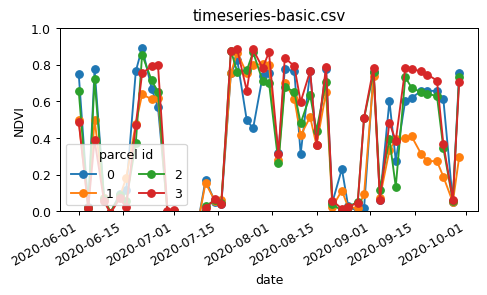

In [10]:
plot_timeseries("ndvi-results/timeseries-basic.csv")

## Cloud Masking in NDVI

The result above is a good start, but there is room for improvement to get smoother NDVI profiles.

There are quite some outliers because we didn't filter out cloudy observations or pixels.
We can use the "SCL" (scene classification) band from the "SENTINEL2_L2A" collection to focus on non-cloud pixels.
Let's load an "SENTINEL2_L2A" data cube again, with the additional "SCL" band, and calculate the NDVI like before:

In [11]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2020-06-01", "2020-10-01"],
    bands=["B04", "B08", "SCL"],
)
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

Now, from the "SCL" band we will build a mask to remove everything that is not class 4 ("vegetation") or 5 ("not vegetated").
This mask data cube is 1 for pixels which we want to remove (clouds, cloud shadow, ...) and 0 for pixels we want to keep.

In [12]:
scl = s2cube.band("SCL")
mask = ~((scl == 4) | (scl == 5))

This mask is however a bit noisy (because of imperfect classification) and to be a bit conservative we also want to expand it a bit to exclude extra pixels at cloud edges. 
We can do this morphological operation by using a convolution with a gaussian kernel and applying a threshold to get a binary mask again.

In [13]:
# 2D gaussian kernel
g = scipy.signal.windows.gaussian(11, std=1.6)
kernel = np.outer(g, g)
kernel = kernel / kernel.sum()

# Morphological dilation of mask: convolution + threshold
mask = mask.apply_kernel(kernel)
mask = mask > 0.1

Now, we mask the NDVI data cube and do aggregation again:

In [14]:
ndvi_masked = ndvi.mask(mask)
timeseries_masked = ndvi_masked.aggregate_spatial(geometries=fields, reducer="mean")

In [15]:
job = timeseries_masked.execute_batch(out_format="CSV", title="Maked NDVI timeseries")

0:00:00 Job 'j-7b1b93be7e624a408e7e91691676170b': send 'start'
0:00:12 Job 'j-7b1b93be7e624a408e7e91691676170b': created (progress N/A)
0:00:17 Job 'j-7b1b93be7e624a408e7e91691676170b': running (progress N/A)
0:00:23 Job 'j-7b1b93be7e624a408e7e91691676170b': running (progress N/A)
0:00:32 Job 'j-7b1b93be7e624a408e7e91691676170b': running (progress N/A)
0:00:42 Job 'j-7b1b93be7e624a408e7e91691676170b': running (progress N/A)
0:00:54 Job 'j-7b1b93be7e624a408e7e91691676170b': running (progress N/A)
0:01:10 Job 'j-7b1b93be7e624a408e7e91691676170b': running (progress N/A)
0:01:29 Job 'j-7b1b93be7e624a408e7e91691676170b': running (progress N/A)
0:01:53 Job 'j-7b1b93be7e624a408e7e91691676170b': running (progress N/A)
0:02:24 Job 'j-7b1b93be7e624a408e7e91691676170b': running (progress N/A)
0:03:01 Job 'j-7b1b93be7e624a408e7e91691676170b': running (progress N/A)
0:03:48 Job 'j-7b1b93be7e624a408e7e91691676170b': finished (progress N/A)


In [16]:
job.get_results().download_file("ndvi-results/timeseries-masked.csv")

PosixPath('ndvi-results/timeseries-masked.csv')

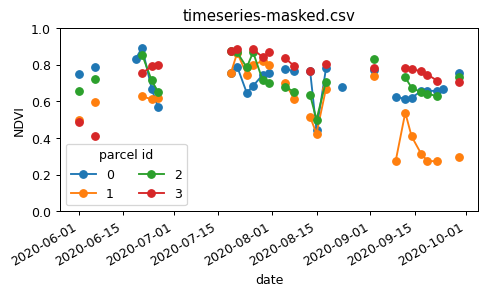

In [17]:
plot_timeseries("ndvi-results/timeseries-masked.csv")

## Timeseries Smoothing

As final step in this demonstration we will add a openEO user-defined function (UDF) to the processing. 
A UDF allows to submit a snippet of, for example, Python code to be executed on the data at the backend side.
In this case we'll define a UDF to:

-  interpolate missing values (due to cloud filtering)
-  apply a Savitzky-Golay filter for temporal smoothing of the timeseries (using `scipy.signal.savgol_filter`)

We can load a UDF from an external file, but here we'll load it as an inline snippet:

In [18]:
udf = openeo.UDF(
    """
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""
)

We apply this UDF along the time dimension of the `ndvi_masked` cube we created in the previous step:

In [19]:
ndvi_smoothed = ndvi_masked.apply_dimension(code=udf, dimension="t")

Now, aggregate this again per field and get the time series.

In [20]:
timeseries_smoothed = ndvi_smoothed.aggregate_spatial(geometries=fields, reducer="mean")

In [21]:
job = timeseries_smoothed.execute_batch(
    out_format="CSV", title="Smoothed NDVI timeseries"
)

0:00:00 Job 'j-465abc149b04431cbe9d4ea21a029c90': send 'start'
0:00:11 Job 'j-465abc149b04431cbe9d4ea21a029c90': created (progress N/A)
0:00:17 Job 'j-465abc149b04431cbe9d4ea21a029c90': created (progress N/A)
0:00:23 Job 'j-465abc149b04431cbe9d4ea21a029c90': running (progress N/A)
0:00:31 Job 'j-465abc149b04431cbe9d4ea21a029c90': running (progress N/A)
0:00:41 Job 'j-465abc149b04431cbe9d4ea21a029c90': running (progress N/A)
0:00:53 Job 'j-465abc149b04431cbe9d4ea21a029c90': running (progress N/A)
0:01:09 Job 'j-465abc149b04431cbe9d4ea21a029c90': running (progress N/A)
0:01:28 Job 'j-465abc149b04431cbe9d4ea21a029c90': running (progress N/A)
0:01:52 Job 'j-465abc149b04431cbe9d4ea21a029c90': running (progress N/A)
0:02:22 Job 'j-465abc149b04431cbe9d4ea21a029c90': running (progress N/A)
0:03:00 Job 'j-465abc149b04431cbe9d4ea21a029c90': running (progress N/A)
0:03:46 Job 'j-465abc149b04431cbe9d4ea21a029c90': finished (progress N/A)


In [22]:
job.get_results().download_file("ndvi-results/timeseries-smoothed.csv")

PosixPath('ndvi-results/timeseries-smoothed.csv')

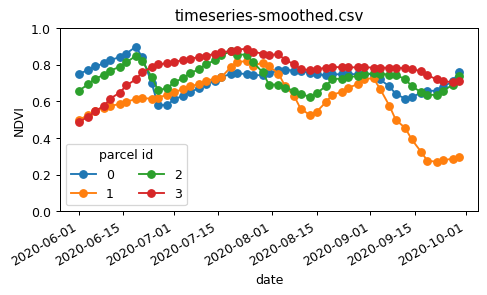

In [23]:
plot_timeseries("ndvi-results/timeseries-smoothed.csv")